# Agent 3

Develop the code for an agent that emulates the intuitive policy of:  *Turn up the heat really hot, then turn it down low to accelerate the heating of the griddle*

In [172]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GridSimulator

## Develop the methodology of hot then cold

This agent is supposed to turn up the *hot side* to a specific temperature (`temperatureHot`) for a specific amount of time (`timeHot`).  After that time, turn the temperature down to a specific temperature (`temperatureCold`) and complete the simulation and score the results

In [7]:
temperatureHot = 300
temperatureCold = 100
timeHot = 600

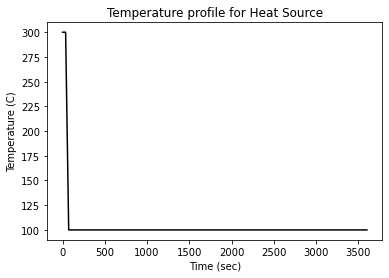

In [3]:
timeTest = np.linspace(0, 3600, 100)

temperatureHeatSourceProfile = np.ones(timeTest.shape)*temperatureCold

isHot = timeTest < timeHot
temperatureHeatSourceProfile[isHot] = temperatureHot

plt.figure()
plt.plot(timeTest, temperatureHeatSourceProfile, '-k')
plt.xlabel("Time (sec)")
plt.ylabel("Temperature (C)")
plt.title("Temperature profile for Heat Source")
plt.show()

In [16]:
class ClassAgent3: 
#     temperatureHot = 300
#     temperatureCold = 100
#     timeHot = 60
    
    def temperatureProfile(self, timeAssess):
        temperatureResult = self.temperatureCold
        if(timeAssess < self.timeHot):
            temperatureResult = self.temperatureHot
        return temperatureResult
    
    def runSimulation(self, timeTotal, timeHot, temperatureHot, temperatureCold, objHeatSimulator):
        score = 0
        
        # run simulation with temperature profile
        
        dTimeRecommend = objHeatSimulator.SuggestedTimeInc(True)
        
        # run the simulator for the hot temperature for a duration of hot time
        timeStart = 0
        timeEnd = timeHot
        noStepsMin =( timeEnd - timeStart)/dTimeRecommend
        noSteps = int(np.ceil(noStepsMin*1.2))
        timeSequence = np.linspace(timeStart, timeEnd, noSteps)
        dTimeLinspace = timeSequence[1] - timeSequence[0]

        objHeatSimulator.TimeInc = dTimeLinspace
        objHeatSimulator.SetHeatSource(temperatureHot)
        objHeatSimulator.CreateDF()
        objHeatSimulator.AdvanceSimulationByTime(timeHot, temperatureHot)
        
        # run the simulator for the cold temperature until the end of the total time
        timeStart = timeHot
        timeEnd = timeTotal
        noStepsMin =( timeEnd - timeStart)/dTimeRecommend
        noSteps = int(np.ceil(noStepsMin*1.2))
        timeSequence = np.linspace(timeStart, timeEnd, noSteps)
        dTimeLinspace = timeSequence[1] - timeSequence[0]

        objHeatSimulator.TimeInc = dTimeLinspace

        objHeatSimulator.SetHeatSource(temperatureCold)
        objHeatSimulator.AdvanceSimulationByTime((timeTotal-timeHot), temperatureCold)

        #Evaluate the score of the simulation
        self.objHeatSimulator = objHeatSimulator
        
        isTemperatureGoodForCooking = (objHeatSimulator.AllTemp.Node10 > 130) & \
            (objHeatSimulator.AllTemp.Node10 < 135)
        
        scoreOverTime = -np.ones(isTemperatureGoodForCooking.shape)
        scoreOverTime[isTemperatureGoodForCooking] = 1.0
        
        scoreIntegral = np.trapz(scoreOverTime, objHeatSimulator.AllTemp.Time.to_numpy())
        score = scoreIntegral / np.max(objHeatSimulator.AllTemp.Time)
        
        return score
    

#  Test the Agent Class

Make sure that temperature vs. time looks right for the heater and the simulator

-0.9294117647058824


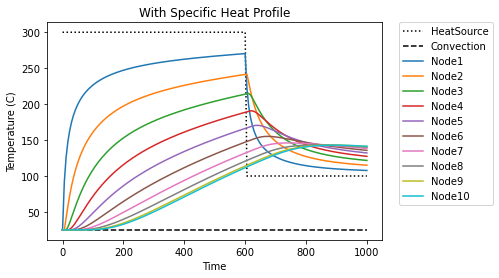

In [242]:
numberNodes = 10
thicknessTotal = 0.1
widthBar = 0.003
thicknessBar = 0.003

materialDensity = 7800
materialSpecificHeat = 500
materialThermalConductivity = 16.2

convectionCoefficient = 4
convectionTemperature = 25

temperatureHeatSource = 25
temperatureInitialIsothermal = 25
doesSurfaceTemperatureAllowConvection = False

objHeatSimulator = GridSimulator.ClassHeatSimulation()
objHeatSimulator.SetSize(widthBar,thicknessBar)
objHeatSimulator.SetNodes(numberNodes,thicknessTotal)
objHeatSimulator.SetMaterialProperties(materialDensity,materialSpecificHeat,materialThermalConductivity)
objHeatSimulator.SetConvectionProperties(convectionCoefficient,convectionTemperature)
objHeatSimulator.EnableSurfaceHeatTransfer(doesSurfaceTemperatureAllowConvection)
objHeatSimulator.SetHeatSource(temperatureHeatSource)
objHeatSimulator.SetInitalTemp(temperatureInitialIsothermal)
objHeatSimulator.UpdatePropertiesTable()

timeTotal = 1000

objAgent = ClassAgent3()
score = objAgent.runSimulation(timeTotal, timeHot, temperatureHot, temperatureCold, objHeatSimulator)
print(score)
objAgent.objHeatSimulator.GraphResults("With Specific Heat Profile")

0.33650162098435676


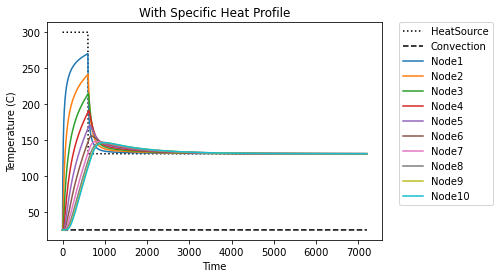

In [243]:
numberNodes = 10
thicknessTotal = 0.1
widthBar = 0.003
thicknessBar = 0.003

materialDensity = 7800
materialSpecificHeat = 500
materialThermalConductivity = 16.2

convectionCoefficient = 4
convectionTemperature = 25

temperatureHeatSource = 25
temperatureInitialIsothermal = 25
doesSurfaceTemperatureAllowConvection = False

objHeatSimulator = GridSimulator.ClassHeatSimulation()
objHeatSimulator.SetSize(widthBar,thicknessBar)
objHeatSimulator.SetNodes(numberNodes,thicknessTotal)
objHeatSimulator.SetMaterialProperties(materialDensity,materialSpecificHeat,materialThermalConductivity)
objHeatSimulator.SetConvectionProperties(convectionCoefficient,convectionTemperature)
objHeatSimulator.EnableSurfaceHeatTransfer(doesSurfaceTemperatureAllowConvection)
objHeatSimulator.SetHeatSource(temperatureHeatSource)
objHeatSimulator.SetInitalTemp(temperatureInitialIsothermal)
objHeatSimulator.UpdatePropertiesTable()

timeTotal = 7200

objAgent = ClassAgent3()
score = objAgent.runSimulation(timeTotal, timeHot, temperatureHot, 131, objHeatSimulator)
print(score)
objAgent.objHeatSimulator.GraphResults("With Specific Heat Profile")

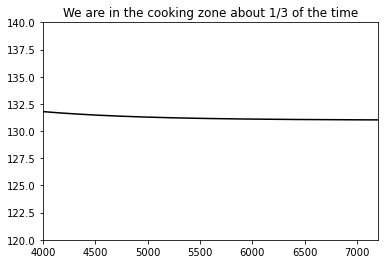

In [15]:
plt.figure()
plt.plot(objAgent.objHeatSimulator.AllTemp.Time, objAgent.objHeatSimulator.AllTemp.Node10, \
         '-k')
plt.ylim(120, 140)
plt.xlim(4000, 7200)
plt.title("We are in the cooking zone about 1/3 of the time")
plt.show()

In [282]:
class Agent3(Env):
    
    def __init__(self):
        self.objHeatSimulator = GridSimulator.ClassHeatSimulation()
        self.objAgent = ClassAgent3()
        self.reset()
        # space (x3) discretes:  one for time, tempHot, tempCold
        self.action_space = MultiDiscrete([ 9, 3, 3 ])
        
        self.listTemperatureHot = np.array([200, 300, 400, 500])
        self.listTemperatureCold = np.array([100, 125, 150, 175])
        self.listTimeHot = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])
        
        self.observation_space = Box(low=-2, high=2, shape=(1,))

        self.timeTotal = 3600

        self.state = 0
        
    def step(self, action):
        #  An action is to run the entire simulation with the (x3) parameters that are chosen
        timeHot = self.listTimeHot[action[0]]
        temperatureHot = self.listTemperatureHot[action[1]]
        temperatureCold = self.listTemperatureCold[action[2]]
        
            
        
        score = self.objAgent.runSimulation(self.timeTotal, timeHot, temperatureHot, temperatureCold, self.objHeatSimulator)

        self.state = score
        reward = score
        done = True
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    def render(self):
        pass
    
    def reset(self):
        self.state = 0
        
        numberNodes = 10
        thicknessTotal = 0.1
        widthBar = 0.003
        thicknessBar = 0.003

        materialDensity = 7800
        materialSpecificHeat = 500
        materialThermalConductivity = 16.2

        convectionCoefficient = 4
        convectionTemperature = 25

        temperatureHeatSource = 25
        temperatureInitialIsothermal = 25
        doesSurfaceTemperatureAllowConvection = False

        self.objHeatSimulator.SetSize(widthBar,thicknessBar)
        self.objHeatSimulator.SetNodes(numberNodes,thicknessTotal)
        self.objHeatSimulator.SetMaterialProperties(materialDensity,materialSpecificHeat,materialThermalConductivity)
        self.objHeatSimulator.SetConvectionProperties(convectionCoefficient,convectionTemperature)
        self.objHeatSimulator.EnableSurfaceHeatTransfer(doesSurfaceTemperatureAllowConvection)
        self.objHeatSimulator.SetHeatSource(temperatureHeatSource)
        self.objHeatSimulator.SetInitalTemp(temperatureInitialIsothermal)
        self.objHeatSimulator.UpdatePropertiesTable()
        
        self.objAgent = ClassAgent3()
        
        return self.state

In [224]:
from gym import Env

**Testing Env**

In [283]:
env = Agent3()

In [249]:
env.objAgent.objHeatSimulator.NumNodes

10

In [250]:
env.objAgent.objHeatSimulator.AllTemp

,Time,Heater,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,Node10,Convection
0,0.000000,400.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
1,6.000000,400.0,118.461538,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
2,12.000000,400.0,165.336095,48.293491,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
3,18.000000,400.0,194.650942,71.658655,30.805455,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
4,24.000000,400.0,215.176783,92.130243,39.540431,26.446898,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,376.216216,125.0,125.528771,124.687540,121.492130,115.610197,107.434914,97.965000,88.551504,80.599356,75.300762,73.443242,25.0
64,382.162162,125.0,125.190401,124.106092,120.828598,115.043773,107.115159,97.978934,88.912436,81.254745,76.150657,74.360803,25.0
65,388.108108,125.0,124.875566,123.564407,120.209324,114.514288,106.816897,97.996156,89.260391,81.885448,76.969225,75.244939,25.0
66,394.054054,125.0,124.582462,123.059588,119.631390,114.019735,106.539446,98.017143,89.596494,82.492716,77.757587,76.096686,25.0


In [291]:
Action = MultiDiscrete([ 10, 4, 4 ]).sample()
env.step(Action)

(-0.9351230425055916, -0.9351230425055916, True, {})

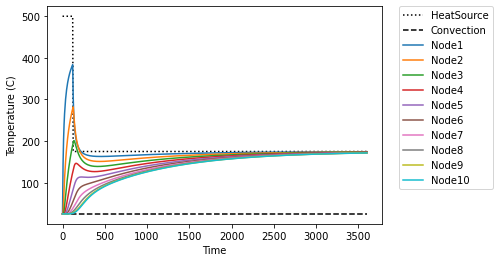

In [292]:
env.objAgent.objHeatSimulator.GraphResults("")

**Debuged verison to be put in new notebook**